In [1]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image, UnidentifiedImageError
from pathlib import Path

import torch.nn
import torchvision
import tensorflow as tf
import torchvision.transforms as transforms
import keras.optimizers
from tensorflow.keras import initializers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, Model
from sklearn.metrics import precision_score, recall_score, f1_score, mean_squared_error
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate, Dropout

In [19]:
# Specify csv file with humidity temperature and picture information
df = pd.read_csv("./data/output_10000.csv")
# The 5 columns here can use humidity and temperature
print(df.shape)
df.head()

(10000, 5)


,stationId,imageDate,imgPath,humidity,temperature C 2m
0,1193-0,6/12/2018 14:01,1193-0/93/1544104893_1193-0.jpg,99.3,0.0
1,1239-0,14/12/2018 10:50,1239-0/24/1544784624_1239-0.jpg,91.9,-1.2
2,1193-0,6/03/2019 8:14,1193-0/41/1551860041_1193-0.jpg,98.3,2.3
3,1154-0,7/03/2019 10:25,1154-0/30/1551954330_1154-0.jpg,64.0,10.2
4,1163-1,21/11/2018 10:45,1163-1/26/1542797126_1163-1.jpg,90.7,-0.1


In [20]:
#finds nth occurence of character in a string
def find_nth(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start+len(needle))
        n -= 1
    return start

In [21]:
import warnings
warnings.filterwarnings('ignore')

correctPaths = []
faultyPaths = []
#first drop rows that have faulty images
for i in range(10000-1, -1, -1):
    
    imgPath = "./data/save_10000/" + df.iloc[i][2]
    df.iloc[i][2] = imgPath

    j = find_nth(imgPath, "/", 6)
    if imgPath[j+1] == "0":
        imgPath = imgPath[:j+1] + imgPath[j+2:]
    try:
        img = Image.open(Path(imgPath))
        correctPaths.append(imgPath)
    except:
        faultyPaths.append(imgPath)
        df.drop(i, inplace = True)

In [5]:
df.shape

(8374, 5)

In [6]:
df["imgPath"] = correctPaths

In [7]:
sample1000 = df.sample(frac = (1000 / 8374))
print(sample1000.shape)
sample1000.head()

(1000, 5)


,stationId,imageDate,imgPath,humidity,temperature C 2m
2278,1093-1,28/11/2018 9:47,./data/save_10000/1085-1/31/1545564331_1085-1.jpg,83.0,-1.5
3203,150-1,12/12/2018 8:52,./data/save_10000/1156-0/23/1549199123_1156-0.jpg,96.8,0.2
309,1236-0,28/02/2019 9:15,./data/save_10000/1085-1/13/1552464613_1085-1.jpg,49.6,11.2
3288,1157-1,27/12/2018 12:45,./data/save_10000/1154-1/33/1551774333_1154-1.jpg,92.7,4.8
4285,1497-0,27/02/2019 9:57,./data/save_10000/137-1/84/1549809184_137-1.jpg,86.7,9.2


In [8]:
transformation = torchvision.transforms.Compose([
        transforms.Resize((256, 256)),
        #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

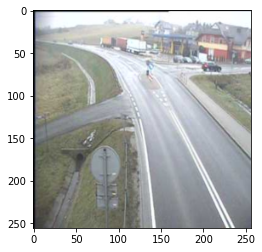

In [10]:
humidityFeature = np.asarray(sample1000["humidity"])
temperatureFeature = np.asarray(sample1000["temperature C 2m"])

imgFeature = []
imgPaths = sample1000["imgPath"]
for i in range(sample1000.shape[0]):
    imgPath = sample1000.iloc[i][2]
    
    #resize and normalise
    img = Image.open(Path(imgPath))
    img = img.convert('RGB')
    transformedImg = transformation(img)
    transformedImg = np.asarray(transformedImg)
    transformedImg = transformedImg / 255
    
    imgFeature.append(transformedImg)
    
    if i % 1000 == 0:
        plt.imshow(transformedImg)
        plt.show()
    
imgFeature = np.asarray(imgFeature)
#example image

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(imgFeature, temperatureFeature, test_size=0.10)
X_train = np.asarray(X_train)
Y_train = np.asarray(Y_train)
X_test = np.asarray(X_test)
Y_test = np.asarray(Y_test)

In [12]:
#define a simple model
image_input = Input(batch_size=8, shape=(256, 256, 3))
conv1 = Conv2D(32, (3, 3), 1, padding="same", activation='relu')(image_input)
conv2 = Conv2D(64, (3, 3), 1, activation='relu')(conv1)
maxpool1 = MaxPooling2D((2, 2))(conv2)
dropout = Dropout(0.25)(maxpool1)

flatten = Flatten()(dropout)
image_dense = Dense(128, activation='relu')(flatten)
output = Dense(1, activation='linear')(image_dense)

model = Model(inputs=image_input, outputs=output)

model.compile(optimizer='adam', loss='mean_squared_error') 

print(model.summary())

history = model.fit(X_train, Y_train, validation_split=0.2, epochs=5, batch_size=8, verbose=1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(8, 256, 256, 3)]        0         
                                                                 
 conv2d (Conv2D)             (8, 256, 256, 32)         896       
                                                                 
 conv2d_1 (Conv2D)           (8, 254, 254, 64)         18496     
                                                                 
 max_pooling2d (MaxPooling2  (8, 127, 127, 64)         0         
 D)                                                              
                                                                 
 dropout (Dropout)           (8, 127, 127, 64)         0         
                                                                 
 flatten (Flatten)           (8, 1032256)              0         
                                                             

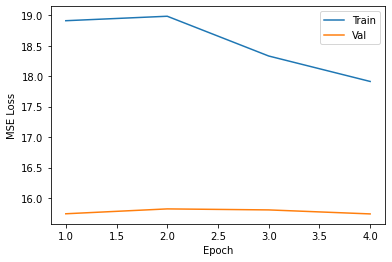

In [14]:
#just plot epochs 2-5
epochs = np.arange(1,5)
plt.plot(epochs, history.history['loss'][1:])
plt.plot(epochs, history.history['val_loss'][1:])
plt.legend(["Train", "Val"])
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()

In [15]:
#compare predictions with baseline that uses training set and outputs mean temperature
Y_pred = np.transpose(np.asarray(model.predict(X_test)))[0]
Y_base = [np.mean(Y_train) for i in range(len(X_test))]

rmse = np.sqrt(((Y_test - Y_base)**2).mean(axis=0))
print("Base RMSE {}".format(rmse))
rmse = np.sqrt(((Y_test - Y_pred)**2).mean(axis=0))
print("Model RMSE {}".format(rmse))

#print some sample predictions
numPreds = len(Y_test)
print("True \t Pred")
for i in range(25):
    print("{} \t {}".format(Y_test[i], np.round(Y_pred[i], 1)))

4/4 [==============================] - 2s 324ms/step
Base RMSE 4.190887734120302
Model RMSE 4.273206771477344
True 	 Pred
3.7 	 2.799999952316284
4.0 	 3.5999999046325684
9.0 	 3.799999952316284
3.9 	 3.200000047683716
8.4 	 3.799999952316284
7.6 	 4.099999904632568
0.0 	 3.5999999046325684
9.9 	 3.0999999046325684
3.4 	 3.0
9.9 	 3.5999999046325684
1.3 	 3.0999999046325684
2.1 	 3.5999999046325684
10.7 	 3.700000047683716
3.3 	 3.0999999046325684
-1.9 	 3.299999952316284
2.7 	 3.4000000953674316
19.5 	 4.699999809265137
3.1 	 3.299999952316284
0.0 	 3.700000047683716
3.6 	 2.700000047683716
3.9 	 2.9000000953674316
0.3 	 3.0
3.8 	 3.200000047683716
0.3 	 3.5
5.6 	 3.4000000953674316


In [16]:
#sort true,estimate pairs by order of lowest true
estimates = [(Y_test[i], Y_pred[i]) for i in range(numPreds)]
estimates.sort(key=lambda x:x[0])
print(estimates[0:10])

[(-2.0, 4.1705685), (-1.9, 3.3293076), (-1.2, 4.092446), (-1.2, 3.8013084), (-1.1, 3.106112), (-0.7, 3.2212536), (-0.7, 2.8803706), (-0.6, 3.3383713), (-0.6, 3.675776), (-0.6, 3.3208077)]


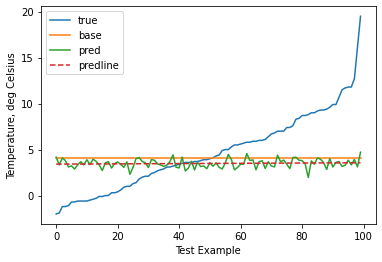

In [17]:
x = np.arange(numPreds)
y1 = [estimates[i][0] for i in range(numPreds)]
y2 = [estimates[i][1] for i in range(numPreds)]

plt.plot(x, y1)
plt.plot(x, Y_base)
plt.plot(x, y2)
yfit = np.polyfit(x, y2, 3)
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y2, 1))(np.unique(x)), '--')
plt.xlabel("Test Example")
plt.ylabel("Temperature, deg Celsius")
plt.legend(["true", "base", "pred", "predline"])
plt.show()

Although the model trained here was quite simple - we have done tests on more complex models and with more training examples.
The main takeaway is that we always seem to end up with a model that just predicts some temperature value around the mean. As  you can see with the baseline prediction in orange, the model predictions in green, and a line of best fit of the model predictions in red. Basically, it seems the model is not picking up any information from the actual images. We would expect to see at least some positive prediction line.

Similarly, the plot of the training/val loss is quite constant - meaning the model doesn't improve after the first epoch.

Then see the experiments for the file Chu_CNN.ipynb